# Freshwater Runoff 

In this notebook, we will filter the freshwater data to our fjord regions of interest 

### Data needed to run this notebook: 

#### Mankoff Freshwater Runoff data:
Mankoff, Ken, 2020, "[Streams, Outlets, Basins, and Discharge [k=1.0]](https://dataverse.geus.dk/dataset.xhtml;jsessionid=6106e4bdc302658ebabae4532699.proddataverse02?persistentId=doi%3A10.22008%2FFK2%2FXKQVL7&version=&q=&fileTypeGroupFacet=%22Data%22&fileAccess=&fileTag=&fileSortField=&fileSortOrder=)", https://doi.org/10.22008/FK2/XKQVL7, GEUS Dataverse, V5 

Specifically, 

`freshwater/ice/outlets.csv`

`freshwater/land/outlets.csv`

`freshwater/ice/MAR.nc`

`freshwater/land/MAR.nc`

#### Fjord Polygons Shapefiles:
Download it here: [Fjord Shapefiles](https://drive.google.com/file/d/1lEkHKa-Fgl-UknROEccnuc2W59ui6C0F/view?usp=drive_link)
<!-- 
#### Cholorphyll Data:
Download it here: [Chlorophyll Data](https://drive.google.com/drive/folders/1LfConKMAZuFDirtopHF6cCnxKPjTdAO5?usp=drive_link) -->



In [1]:
# system
import os
import time 

# data manipulation
import xarray as xr
import pandas as pd
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# spatial
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs

## Part 1: Subset the Mankoff freshwater outlets 
### Prepare fjord polygons
First, we slightly expand the polygons to ensure they will encapsulate all of the Mankoff data locations that lie on the polygon boundary. 

In [2]:
# buffer polygons 
# PATH TO FJORD POLYGON SHAPEFILE
file = os.path.expanduser('~/Data/Polygons/Greenland_ExtRegions/Greenland_ExtRegions_Master_20240711.shp')
polygons_buffered = gpd.read_file(file)
polygons_buffered = polygons_buffered.to_crs(epsg=3413)
polygons_buffered['geometry'] = polygons_buffered['geometry'].buffer(10000)
polygons_buffered = polygons_buffered.to_crs(epsg=4326)


polygons = gpd.read_file(file)

### Read in the Data Outlets

In [3]:
ice_fp = '/home/tara/Data/Mankoff/ice/'
ice_outlets_fn = 'outlets.csv'
land_fp = '/home/tara/Data/Mankoff/land/'
land_outlets_fn = 'outlets.csv'


ice_outlets = pd.read_csv(ice_fp + ice_outlets_fn)
ice_outlets = ice_outlets[ice_outlets['elev'] <= -50]

land_outlets = pd.read_csv(land_fp + land_outlets_fn)
land_outlets = land_outlets[land_outlets['elev'] <= -50]

### Visualize the data outlets

I like to see what I'm working with. Let's get a visual on where the available data is. 

In this plot, we color the original fjord regions orange and color the extension in yellow. Then, we plot the outlets and color them by elevation

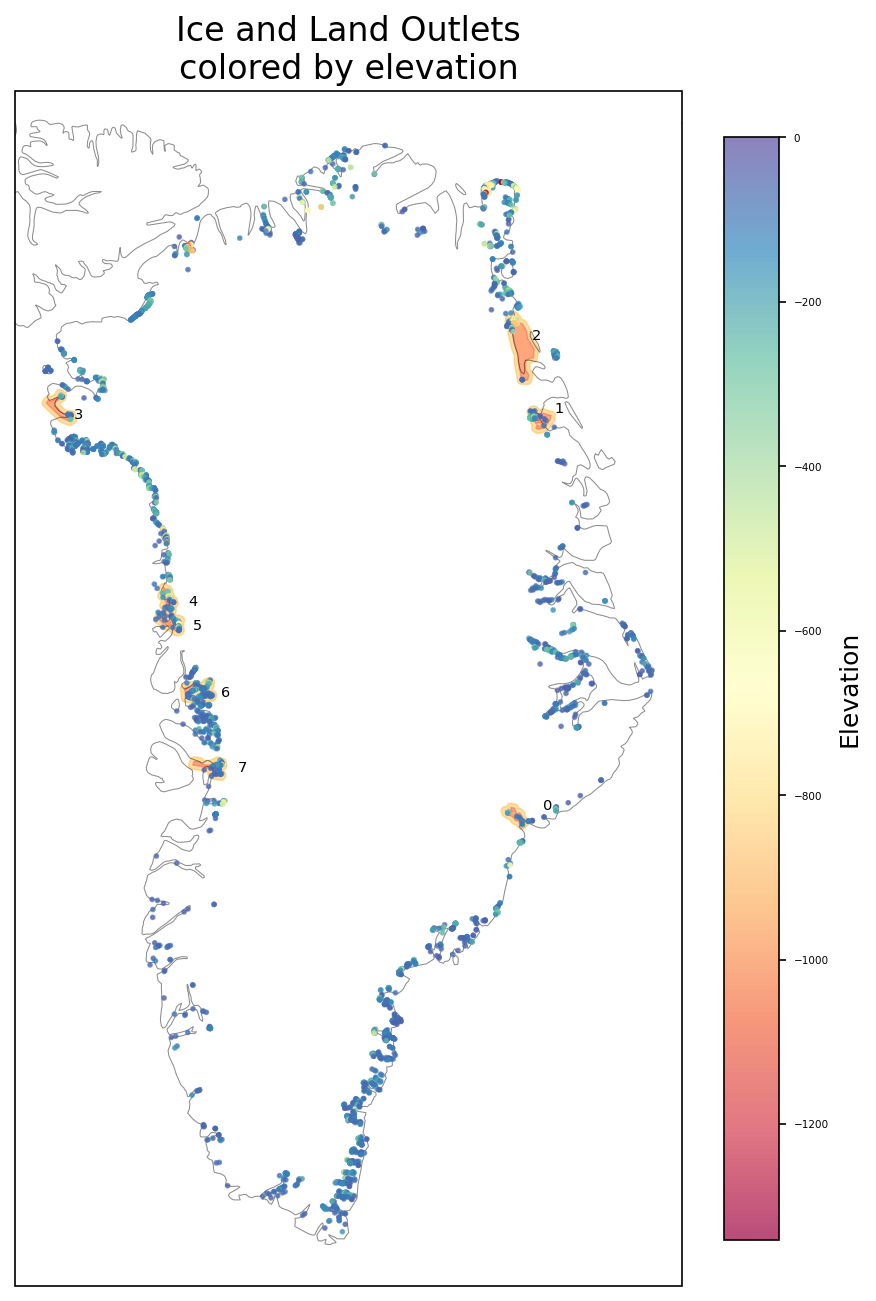

In [32]:
fig, ax = plt.subplots(figsize=(6, 15), dpi=150, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})

# plot the extended fjord polygons
for index, row in polygons_buffered.iterrows():
        label = row['id']

        geometry = row['geometry']
        # ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = '#c1121f')
        ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = 'orange', alpha = 0.35)

        centroid = geometry.centroid
        x_centroid, y_centroid = centroid.x, centroid.y
        
        valign, halign = 'center', 'center'
        x_text, y_text = x_centroid + 2, y_centroid + 0.05


# plot the original fjord polygons
for index, row in polygons.iterrows():
        label = row['id']

        geometry = row['geometry']
        # ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = 'purple')
        ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = 'red', alpha = 0.25)

        centroid = geometry.centroid
        x_centroid, y_centroid = centroid.x, centroid.y
        
        valign, halign = 'center', 'center'
        x_text, y_text = x_centroid + 2, y_centroid + 0.05

        ax.text(x_text, y_text, label, transform=ccrs.PlateCarree(), fontsize=7, ha=halign, va=valign)

# plot the ice and land outlets
scatter = ax.scatter(ice_outlets['lon'], ice_outlets['lat'], c=ice_outlets['elev'], cmap='Spectral', transform=ccrs.PlateCarree(), s=3, alpha=.7, zorder=100, vmax=0) #, edgecolors='black', linewidth=0.5)
scatter = ax.scatter(land_outlets['lon'], land_outlets['lat'], c=land_outlets['elev'], cmap='Spectral', transform=ccrs.PlateCarree(), s=3, alpha=.7, zorder=100, vmax=0)#, edgecolors='black', linewidth=0.5)

ax.coastlines(linewidth=0.5, alpha=0.45)

colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
colorbar.ax.tick_params(labelsize=5)
colorbar.set_label('Elevation', fontsize=12)

plt.title('Ice and Land Outlets\ncolored by elevation', fontdict={'fontsize': 16})

plt.tight_layout()
plt.show()

## Subset the Outlets to our Regions of Interest
(selected fjords from polygons)

In [38]:
polygons_gdf = gpd.GeoDataFrame(polygons_buffered, geometry='geometry', crs='EPSG:4326')

# create GeoDataFrame for ice outlets and reproject to match polygons_gdf
ice_outlets_gdf = gpd.GeoDataFrame(ice_outlets, geometry=[Point(xy) for xy in zip(ice_outlets.lon, ice_outlets.lat)], crs='EPSG:4326')
ice_outlets_within_polygons = gpd.sjoin(ice_outlets_gdf, polygons_gdf, how='inner', predicate='intersects')

# again, for land outlets
land_outlets_gdf = gpd.GeoDataFrame(land_outlets, geometry=[Point(xy) for xy in zip(land_outlets.lon, land_outlets.lat)], crs='EPSG:4326')
land_outlets_within_polygons = gpd.sjoin(land_outlets_gdf, polygons_gdf, how='inner', predicate='intersects')

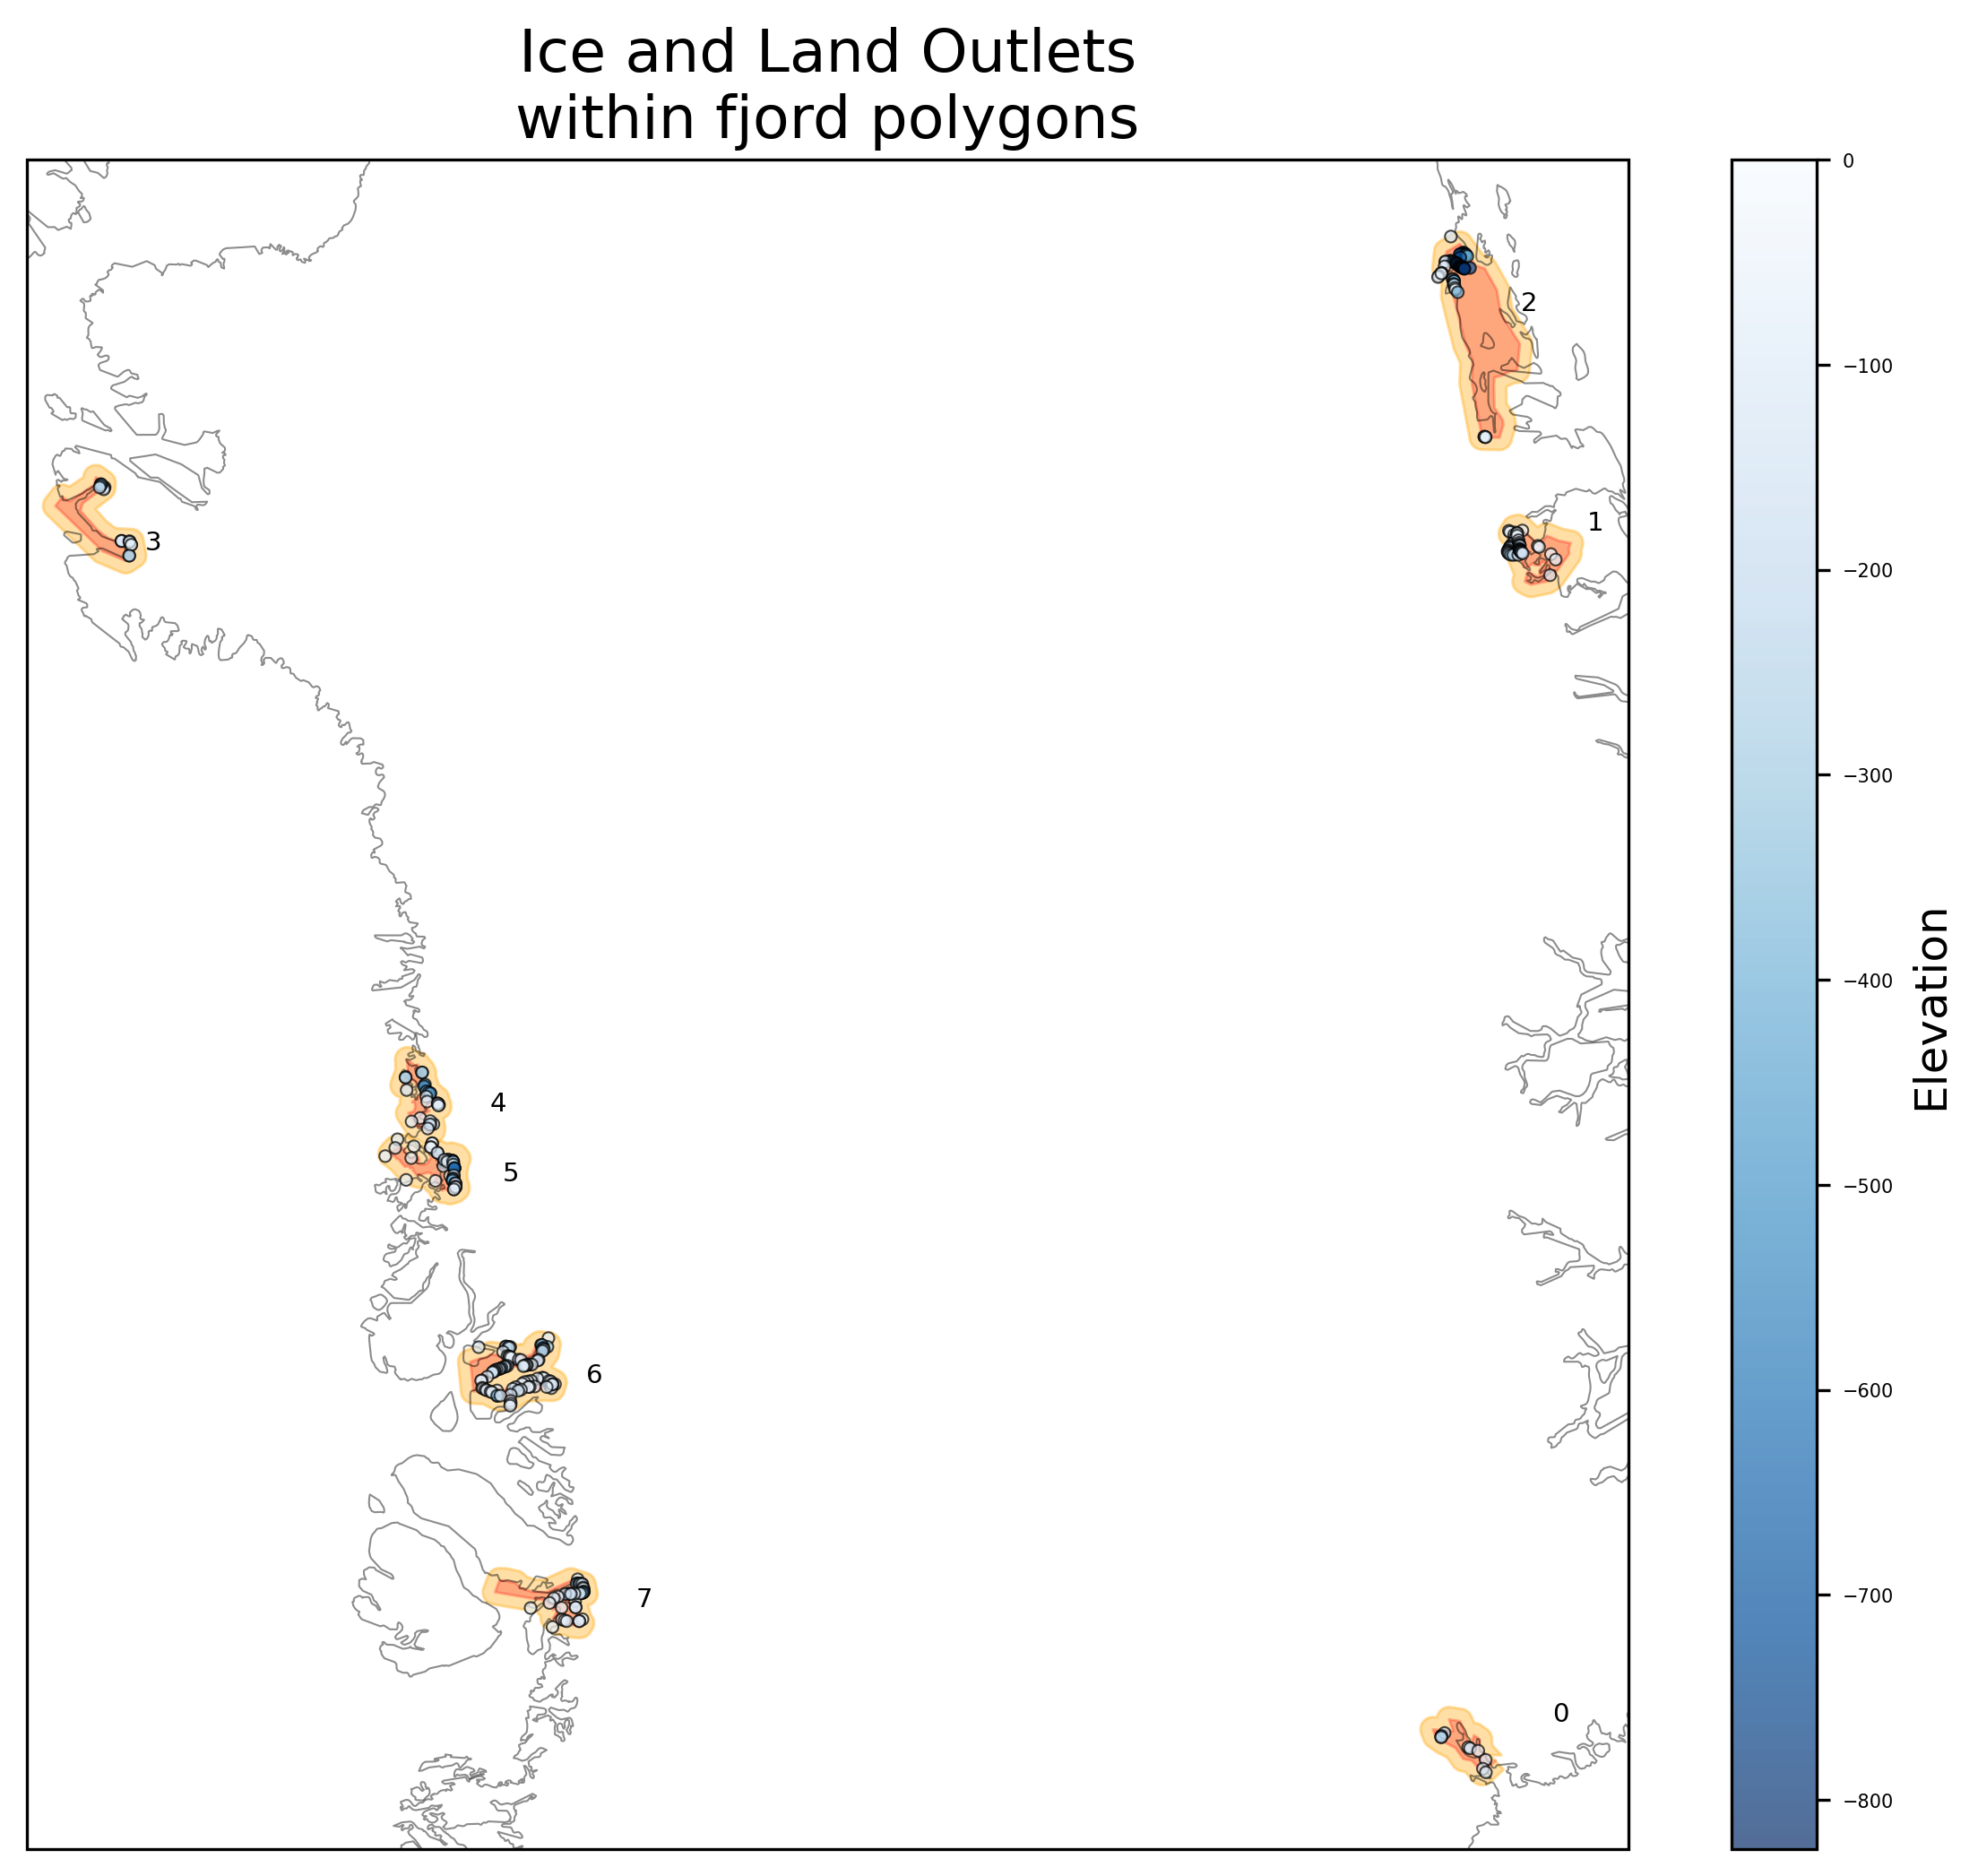

In [34]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=300, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})

# plot the extended fjord polygons
for index, row in polygons_buffered.iterrows():
        label = row['id']

        geometry = row['geometry']
        ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = 'orange', alpha = 0.35)

        centroid = geometry.centroid
        x_centroid, y_centroid = centroid.x, centroid.y
        
        valign, halign = 'center', 'center'
        x_text, y_text = x_centroid + 2, y_centroid + 0.05

#plot the original fjord polygons
for index, row in polygons.iterrows():
        label = row['id']

        geometry = row['geometry']
        ax.add_geometries([geometry], ccrs.PlateCarree(), label=row['id'], linewidth=0.75, color = 'red', alpha = 0.25)

        centroid = geometry.centroid
        x_centroid, y_centroid = centroid.x, centroid.y
        
        valign, halign = 'center', 'center'
        x_text, y_text = x_centroid + 2, y_centroid + 0.05

        ax.text(x_text, y_text, label, transform=ccrs.PlateCarree(), fontsize=7, ha=halign, va=valign)

# plot the ice and land outlets, colored by elevation
scatter = ax.scatter(ice_outlets_within_polygons['lon'], ice_outlets_within_polygons['lat'], c=ice_outlets_within_polygons['elev'], cmap='Blues_r', transform=ccrs.PlateCarree(), s=10, alpha=.7, zorder=100, vmax=0, edgecolors='black', linewidth=0.5)
scatter = ax.scatter(land_outlets_within_polygons['lon'], land_outlets_within_polygons['lat'], c=land_outlets_within_polygons['elev'], cmap='Blues_r', transform=ccrs.PlateCarree(), s=10, alpha=.7, zorder=100, vmax=0, edgecolors='black', linewidth=0.5)

ax.coastlines(linewidth=0.5, alpha=0.45)

colorbar = plt.colorbar(scatter, ax=ax) #, shrink=0.5)
colorbar.ax.tick_params(labelsize=5)
colorbar.set_label('Elevation', fontsize=12)

plt.title('Ice and Land Outlets\nwithin fjord polygons', fontdict={'fontsize': 16})

plt.tight_layout()
plt.show()

# We know the outlets, now lets filter out the data we don't need

In [50]:
# filter the MAR data to only include the ice outlets within the polygons
ice_fp = '/home/tara/Data/Mankoff/ice/'
land_fp = '/home/tara/Data/Mankoff/land/'
mar_fn = 'MAR.nc'

ice_cat = ice_outlets_within_polygons['cat'].tolist()
ice_mar = xr.open_dataset(ice_fp + mar_fn)

filtered_ice_mar = ice_mar.sel(station=ice_cat)
filtered_ice_mar = filtered_ice_mar.sel(time=slice("1998-01-01", None))
ice_mar.close()

filtered_ice_mar

<xarray.Dataset>
Dimensions:            (station: 127, time: 9131)
Coordinates:
    alt                (station) float32 ...
    lat                (station) float32 ...
    lon                (station) float32 ...
  * station            (station) uint64 23242 23459 23475 ... 60601 63214 63244
  * time               (time) datetime64[ns] 1998-01-01 ... 2022-12-31
Data variables: (12/15)
    discharge          (station, time) float64 ...
    Z2012_sector       (station) uint32 ...
    Z2012_sector_dist  (station) uint32 ...
    M2019_ID           (station) uint32 ...
    M2019_ID_dist      (station) uint32 ...
    M2019_basin        (station) object ...
    ...                 ...
    B2015_name         (station) object ...
    B2015_dist         (station) uint32 ...
    coast_id           (station) uint32 ...
    coast_lat          (station) float32 ...
    coast_lon          (station) float32 ...
    coast_alt          (station) float32 ...
Attributes:
    featureType:      timeSeries
    title:            Greenland discharge
    summary:          Greenland RCM discharge at basin outlets
    keywords:         Hydrology; Greenland; Runoff; Discharge; Freshwater
    Conventions:      CF-1.7
    source:           git commit: 0be7e36
    creator_name:     Ken Mankoff
    creator_email:    kdm@geus.dk
    creator_url:      http://kenmankoff.com
    institution:      GEUS
    references:       10.22008/promice/freshwater
    product_version:  1.0

In [51]:
land_cat = land_outlets_within_polygons['cat'].tolist()
land_mar = xr.open_dataset(land_fp + mar_fn)

land_mar_station = land_mar['station'].values.tolist()
land_list = [x for x in land_cat if x in land_mar_station]


filtered_land_mar = land_mar.sel(station=land_list)
filtered_land_mar = filtered_land_mar.sel(time=slice("1998-01-01", None))

land_mar.close()

filtered_land_mar

<xarray.Dataset>
Dimensions:            (station: 178, time: 9131)
Coordinates:
    alt                (station) float32 ...
    lat                (station) float32 ...
    lon                (station) float32 ...
  * station            (station) uint64 27245 27473 27491 ... 104573 105060
  * time               (time) datetime64[ns] 1998-01-01 ... 2022-12-31
Data variables:
    discharge          (station, time) float64 ...
    Z2012_sector       (station) uint32 ...
    Z2012_sector_dist  (station) uint32 ...
    M2019_ID           (station) uint32 ...
    M2019_ID_dist      (station) uint32 ...
    M2019_basin        (station) object ...
    M2019_region       (station) object ...
    M2020_gate         (station) uint32 ...
    M2020_gate_dist    (station) uint32 ...
    B2015_name         (station) object ...
    B2015_dist         (station) uint32 ...
Attributes:
    featureType:      timeSeries
    title:            Greenland discharge
    summary:          Greenland RCM discharge at basin outlets
    keywords:         Hydrology; Greenland; Runoff; Discharge; Freshwater
    Conventions:      CF-1.7
    source:           git commit: 0be7e36
    creator_name:     Ken Mankoff
    creator_email:    kdm@geus.dk
    creator_url:      http://kenmankoff.com
    institution:      GEUS
    references:       10.22008/promice/freshwater
    product_version:  1.0

### Create a save state

Pickle your data for easy access! These files are used to make poster figures

In [ ]:
import pickle 

filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

with open(filtered_data_fp + 'filtered_ice_mar.pkl', 'wb') as f:
    pickle.dump(filtered_ice_mar, f)

with open(filtered_data_fp + 'filtered_land_mar.pkl', 'wb') as f:
    pickle.dump(filtered_land_mar, f)

with open(filtered_data_fp + 'land_outlets_within_polygons.pkl', 'wb') as f:
    pickle.dump(land_outlets_within_polygons, f)

with open(filtered_data_fp + 'ice_outlets_within_polygons.pkl', 'wb') as f:
    pickle.dump(ice_outlets_within_polygons, f)

## Part 2: Process the runoff
### Load your save state (optional)

You can start from here in the future, if you pickled your data. 

In [ ]:
# system
import os
import time 

# data manipulation
import xarray as xr
import pandas as pd
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# spatial
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs

import pickle 

filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

with open(filtered_data_fp + 'land_outlets_within_polygons.pkl', 'rb') as f:
    land_outlets_within_polygons = pickle.load(f)

with open(filtered_data_fp + 'ice_outlets_within_polygons.pkl', 'rb') as f:
    ice_outlets_within_polygons = pickle.load(f)

In [ ]:
ice_fp = '/home/tara/Data/Mankoff/ice/'
land_fp = '/home/tara/Data/Mankoff/land/'
mar_fn = 'MAR.nc'


land_cat = land_outlets_within_polygons['cat'].tolist()
land_mar = xr.open_dataset(land_fp + mar_fn)

### Process the freshwater data
Store the processed data in pickle files for easy access

#### Process Ice
This may take a while

In [57]:
filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

for i in range(8):
    start_time = time.time()
    print(f"fjord {i} | processing ", end='\r')
    id_ice = ice_outlets_within_polygons[ice_outlets_within_polygons['id'] == i]
    id_ice_cat = id_ice['cat'].tolist()
    id_ice_mar = ice_mar.sel(station=id_ice_cat)
    id_ice_mar = id_ice_mar.sel(time=slice("1998-01-01", None)) 
    total_discharge = id_ice_mar.discharge.sum(dim='station')
    with open(filtered_data_fp + f'{i}_ice_total_discharge.pkl', 'wb') as f:
        pickle.dump(total_discharge, f)
    end_time = time.time()
    duration_minutes = (end_time - start_time) / 60
    print(f"fjord {i} | execution time: {duration_minutes:.2f} minutes")

fjord 0 | execution time: 9.48 minutes
fjord 1 | execution time: 2.51 minutes
fjord 2 | execution time: 5.15 minutes
fjord 3 | execution time: 0.93 minutes
fjord 4 | execution time: 1.45 minutes
fjord 5 | execution time: 3.04 minutes
fjord 6 | execution time: 1.58 minutes
fjord 7 | execution time: 1.84 minutes


#### Process Land
This may take a while

In [58]:
filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

for i in range(8):
    start_time = time.time()
    print(f"fjord {i} | processing ", end='\r')
    
    id_land = land_outlets_within_polygons[land_outlets_within_polygons['id'] == i]
    id_land_cat_0 = id_land['cat'].tolist()

    id_land_cat = [x for x in id_land_cat_0 if x in land_mar['station'].values.tolist()]
    id_land_mar = land_mar.sel(station=id_land_cat)
    id_land_mar = id_land_mar.sel(time=slice("1998-01-01", None)) 
    total_discharge = id_land_mar.discharge.sum(dim='station')
    with open(filtered_data_fp + f'{i}_land_total_discharge.pkl', 'wb') as f:
        pickle.dump(total_discharge, f)
    end_time = time.time()
    duration_minutes = (end_time - start_time) / 60
    print(f"fjord {i} | execution time: {duration_minutes:.2f} minutes")

fjord 0 | execution time: 1.13 minutes
fjord 1 | execution time: 2.82 minutes
fjord 2 | execution time: 1.48 minutes
fjord 3 | execution time: 1.23 minutes
fjord 4 | execution time: 1.96 minutes
fjord 5 | execution time: 2.21 minutes
fjord 6 | execution time: 8.37 minutes
fjord 7 | execution time: 2.71 minutes


## Part 3: Read in and Visualize Runoff

In [2]:
# system
import os
import time 

# data manipulation
import xarray as xr
import pandas as pd
import geopandas as gpd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# spatial
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs

#### Read back in the final filtered discharge from pickles and plot

In [ ]:
# location to the filtered data 
filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

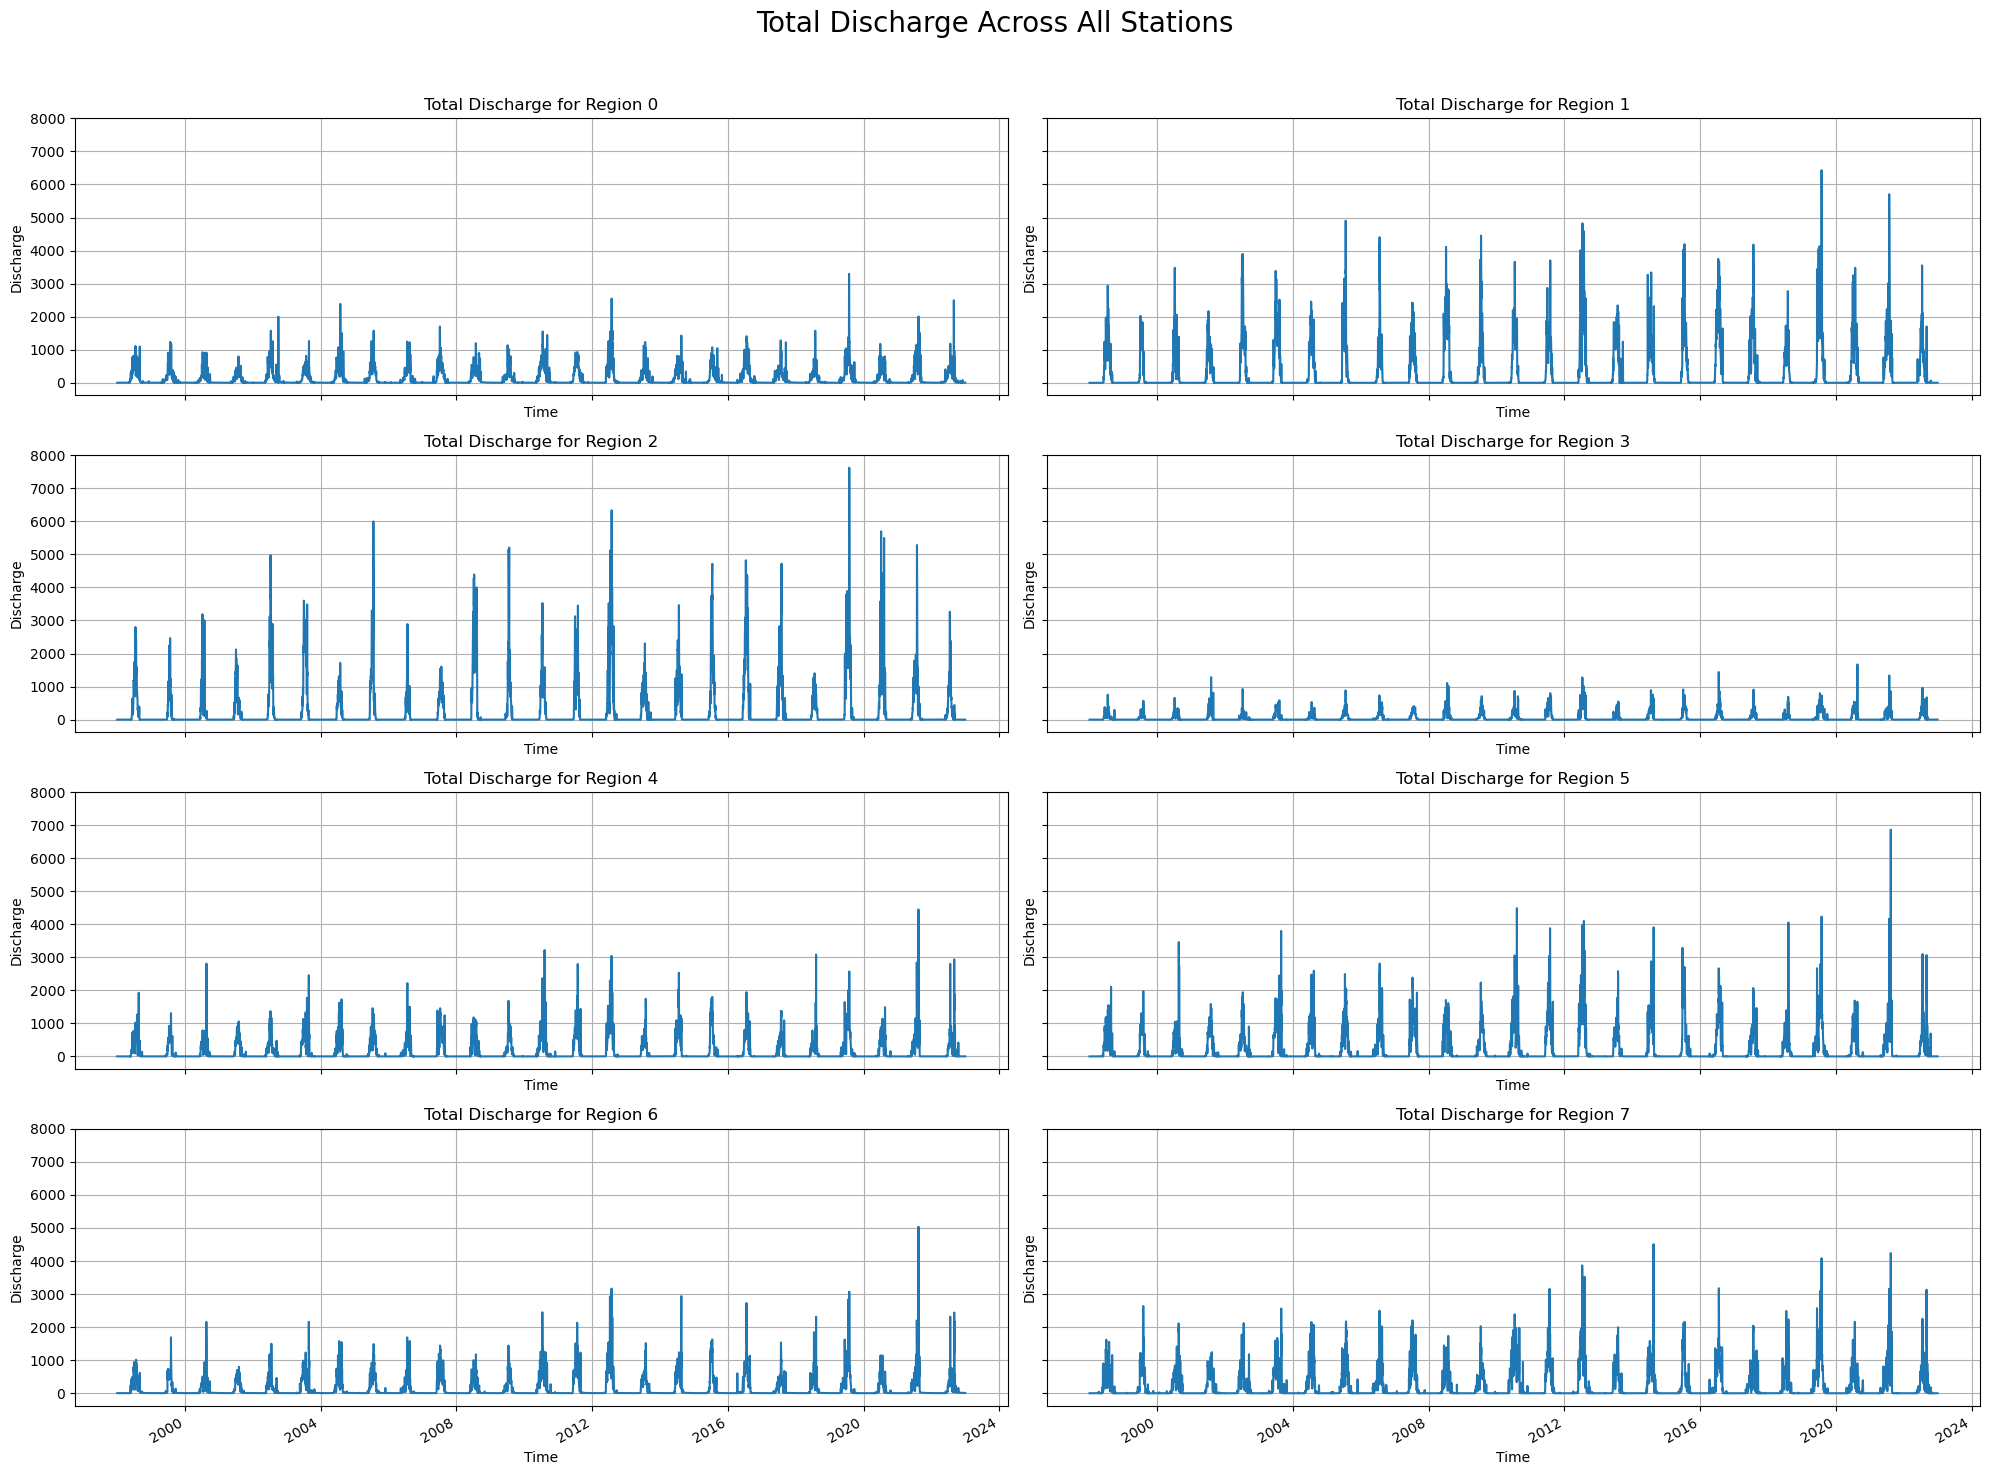

In [4]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(8):

    with open(filtered_data_fp + f'{i}_ice_total_discharge.pkl', 'rb') as f:
        total_discharge_ice = pickle.load(f)

    with open(filtered_data_fp + f'{i}_land_total_discharge.pkl', 'rb') as f:
        total_discharge_land = pickle.load(f)

    total_discharge = total_discharge_ice + total_discharge_land

    ax = axs[i]
    total_discharge.plot(ax=ax)
    ax.set_title(f'Total Discharge for Region {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Discharge')
    ax.grid(True)

    end_time = time.time()
    duration_minutes = (end_time - start_time) / 60

plt.suptitle('Total Discharge Across All Stations', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Looks good!
## Bonus: Get the overall means for Table 1

In [23]:
data_list = []

new_order = [3, 2, 4, 1, 5, 0, 6, 7]
filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'

print('Overall Median Runoff and Chlorophyll-a by Region')
print('Region   |  Discharge   | Chlorophyll-a |' )
for id in new_order:
    # discharge data
    with open(filtered_data_fp + f'{id}_ice_total_discharge.pkl', 'rb') as f:
        total_discharge_ice = pickle.load(f)
    with open(filtered_data_fp + f'{id}_land_total_discharge.pkl', 'rb') as f:
        total_discharge_land = pickle.load(f)
    total_discharge = total_discharge_ice + total_discharge_land
    

    # chlorophyll data
    fjord_file = f'/home/tara/Data/CSVs/extended_fjords/region{id}.csv'
    if os.path.exists(fjord_file):
        fjord = pd.read_csv(fjord_file)
        fjord_yearly_chlora = fjord['chlor_a'].median()
    print(f'Fjord {id}  |     {total_discharge.median().values:.2f}     |     {fjord_yearly_chlora:.2f}      |')

Overall Median Runoff and Chlorophyll-a by Region
Region   |  Discharge   | Chlorophyll-a |
Fjord 3  |     0.34     |     1.41      |
Fjord 2  |     0.01     |     3.49      |
Fjord 4  |     1.23     |     1.82      |
Fjord 1  |     0.63     |     2.85      |
Fjord 5  |     1.17     |     2.53      |
Fjord 0  |     6.94     |     0.82      |
Fjord 6  |     6.64     |     1.82      |
Fjord 7  |     0.41     |     2.23      |
